In [1]:
from api import *
from collections import defaultdict
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score

# Import the traffic data to produce median models
clean_birmingham_report_df_norm = pd.read_feather('high_quality_traffic_reports_two_year/clean_birmingham_report_df_norm')
clean_manchester_report_df_norm = pd.read_feather('high_quality_traffic_reports_two_year/clean_manchester_report_df_norm')
clean_cambridge_report_df_norm = pd.read_feather('high_quality_traffic_reports_two_year/clean_cambridge_report_df_norm')
clean_thorpe_report_df_norm = pd.read_feather('high_quality_traffic_reports_two_year/clean_thorpe_report_df_norm')
clean_epping_report_df_norm = pd.read_feather('high_quality_traffic_reports_two_year/clean_epping_report_df_norm')
clean_bristol_report_df_norm = pd.read_feather('high_quality_traffic_reports_two_year/clean_bristol_report_df_norm')


# Import the traffic data to produce linear models
model_birmingham = pd.read_feather('linear-flow-model/linear-birmingham')
model_manchester = pd.read_feather('linear-flow-model/linear-manchester')
model_cambridge = pd.read_feather('linear-flow-model/linear-cambridge')
model_thorpe = pd.read_feather('linear-flow-model/linear-thorpe')
model_epping = pd.read_feather('linear-flow-model/linear-epping')
model_bristol = pd.read_feather('linear-flow-model/linear-bristol')

reports = {"birmingham": clean_birmingham_report_df_norm,
          "manchester" : clean_manchester_report_df_norm,
          "cambridge" : clean_cambridge_report_df_norm,
          "thorpe" : clean_thorpe_report_df_norm,
          "epping" : clean_epping_report_df_norm,
          "bristol" : clean_bristol_report_df_norm }

linear_model_reports = {"birmingham": model_birmingham,
          "manchester" : model_manchester,
          "cambridge" : model_cambridge,
          "thorpe" : model_thorpe,
          "epping" : model_epping,
          "bristol" : model_bristol }

In [2]:
sites = '175', '561', '1102', '1105', '1608', '1747', '1926', '2017', '2330', '2951', '3103', '4403'

In [3]:
small_report_df = clean_birmingham_report_df_norm[clean_birmingham_report_df_norm.site_id.isin(sites)]

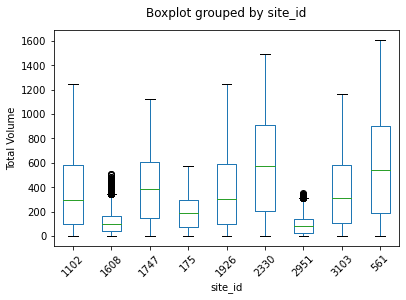

In [4]:
fig, ax = plt.subplots()
small_report_df.boxplot(column='total_volume', by = 'site_id', ax=ax, grid=False, rot=45)
ax.set_title('')
ax.set_ylabel('Total Volume')
plt.savefig('boxplt',dpi=300,  bbox_inches="tight")
plt.show()

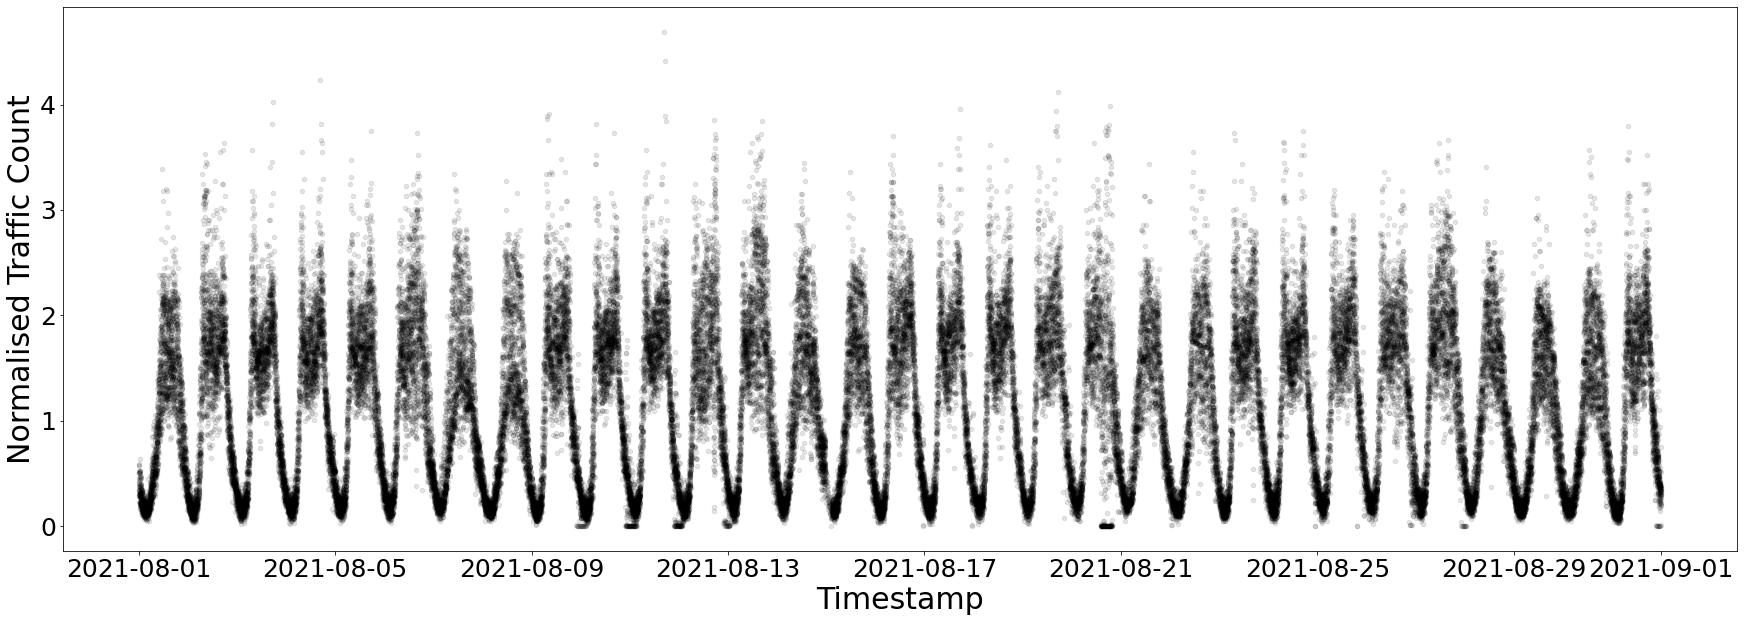

In [5]:
fig, ax = plt.subplots()
filterd_report = clean_birmingham_report_df_norm.loc[clean_birmingham_report_df_norm['timestamp'].dt.to_period('M')  == '2021-08']
filterd_report.plot('timestamp','total_volume_normalised', figsize = (30,10), kind = 'scatter', alpha=0.1, c='black', ax = ax)
ax.tick_params(axis='both', which='major', labelsize=25)
plt.xlabel('Timestamp', size = 30)
plt.ylabel('Normalised Traffic Count', size = 30)
plt.savefig('normalised-traffic-count',dpi=300,  bbox_inches="tight")
plt.show()

In [6]:
def plot_linear_model(actual_report, predictions, start_date, end_date, name = 'flow model'):
    predictions = predictions[predictions.timestamp.between(start_date, end_date)]
    actual_report = actual_report[actual_report.timestamp.between(start_date, end_date)]
        
    fig, ax = plt.subplots(figsize=(15,3))
    predictions.plot('timestamp','total_volume_normalised_predictions', ax=ax, kind = 'line', alpha=1, c='red')
    actual_report.plot('timestamp','total_volume_normalised', ax=ax, kind = 'scatter', alpha=0.25, c='black')
    
    plt.ylabel(f'Normalised Traffic Count')
    plt.xlabel(f'Day of Month')
    ax.legend(["Predicted Normalised Traffic Count"])
    plt.savefig(name, dpi = 300, bbox_inches="tight")

    plt.show()

### Plot the Normalised Values vs Predicted

In [8]:
def get_reports(test_loc):
    train_report = pd.concat([v for k,v in reports.items() if k != test_loc])
    return train_report

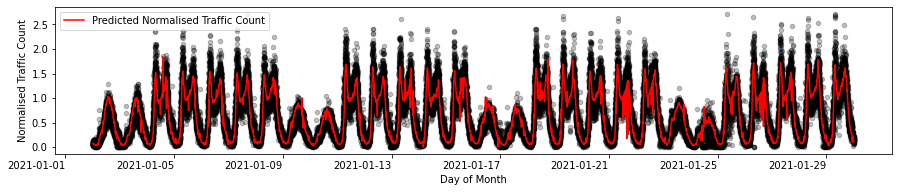

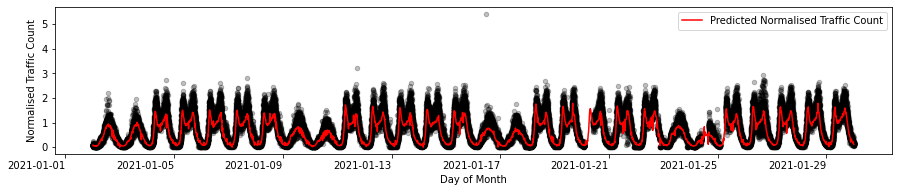

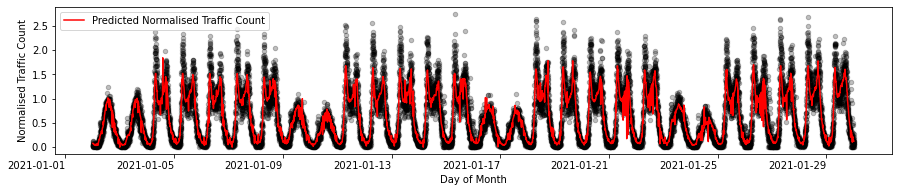

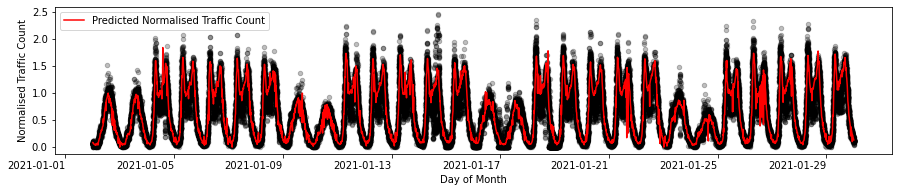

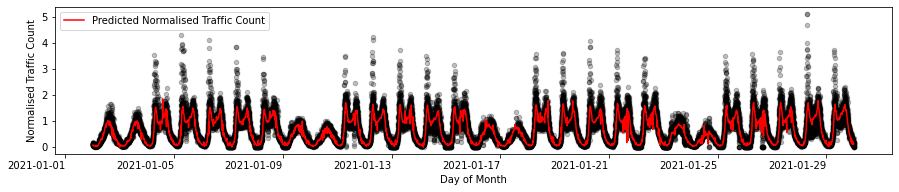

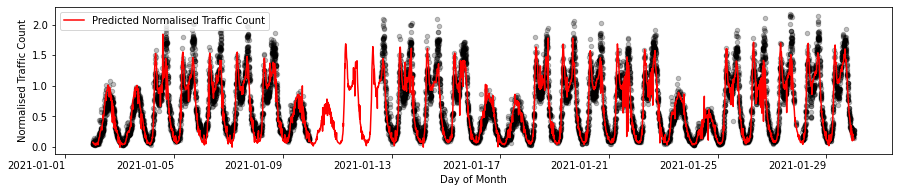

In [9]:
median_models = defaultdict(str)
for k, v in reports.items():
    train_report_df_norm = get_reports(k)
    median_models[k] = train_report_df_norm.groupby('timestamp')['total_volume_normalised'].median().to_frame().reset_index().rename(columns={"total_volume_normalised": "total_volume_normalised_predictions"})
    plot_linear_model(v, 
                  median_models[k], 
                  "2021-01-02 00:14:00", 
                  "2021-01-30 00:14:00", 
                  name = f'median-model-{k}')

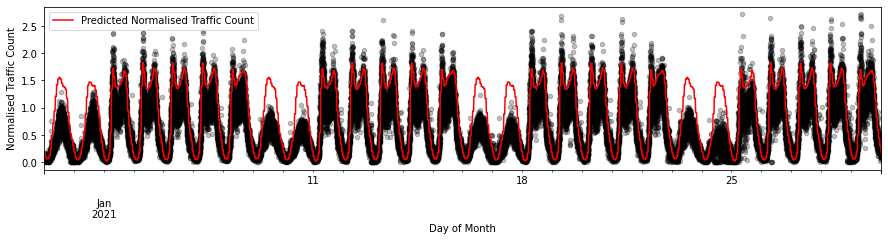

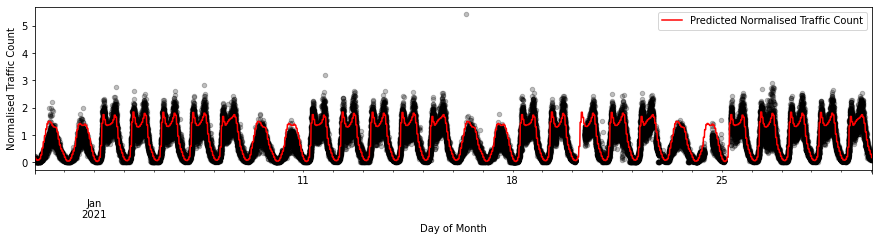

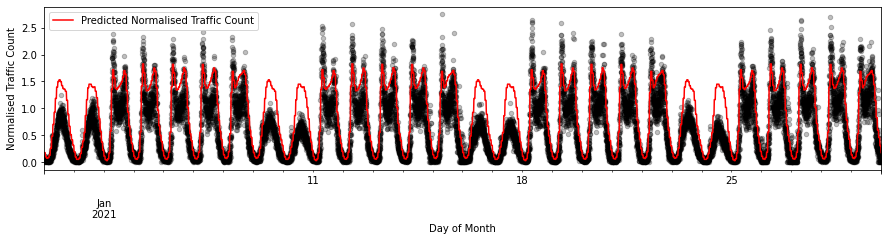

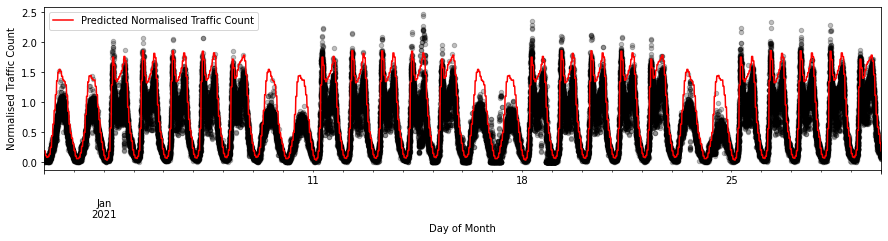

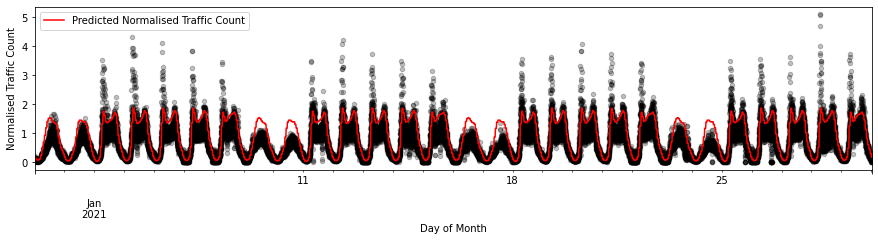

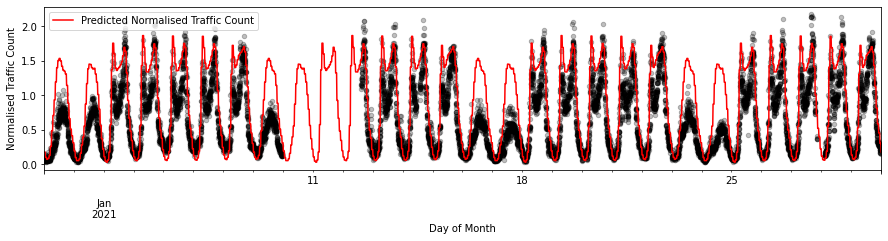

In [15]:
for k, v in reports.items():
    plot_linear_model(v, 
                  linear_model_reports[k], 
                  "2021-01-02 00:14:00", 
                  "2021-01-30 00:14:00", 
                  name = f'linear-model-{k}')

Evaluate Errors

In [10]:
def Evalualte_Norm_Model(clean_report_df_norm, model_report):
    true_v_pred = clean_report_df_norm.merge(model_report, on='timestamp', how='left')[['timestamp', 'total_volume_normalised', 'total_volume_normalised_predictions']]
    true_v_pred = true_v_pred[~true_v_pred.total_volume_normalised_predictions.isnull()]
    return true_v_pred

In [13]:
def eval_norm_loop(area, clean_report_df_norm):
    train_report_df_norm = get_reports(area)
    linear_report = Evalualte_Norm_Model(clean_report_df_norm, linear_model_reports[area])
    linear_report_train = Evalualte_Norm_Model(train_report_df_norm, linear_model_reports[area])
    
    median_report = Evalualte_Norm_Model(clean_report_df_norm, median_models[area])
    median_report_train = Evalualte_Norm_Model(train_report_df_norm, median_models[area])
    
    linear_train_mae = (mean_absolute_error(linear_report_train.total_volume_normalised, linear_report_train.total_volume_normalised_predictions))
    median_train_mae = (mean_absolute_error(median_report_train.total_volume_normalised, median_report_train.total_volume_normalised_predictions))
    
    linear_test_mae = (mean_absolute_error(linear_report.total_volume_normalised, linear_report.total_volume_normalised_predictions))
    median_test_mae = (mean_absolute_error(median_report.total_volume_normalised, median_report.total_volume_normalised_predictions))
    
    print(f"{area}, Linear, {linear_test_mae}, {linear_train_mae} ")
    print(f", Median, {median_test_mae}, {median_train_mae}")

In [14]:
print(",,Test Set,Train Set")
print(",,MAE,MAE")

for area, clean_report_df_norm in reports.items():
    eval_norm_loop(area, clean_report_df_norm)

,,Test Set,Train Set
,,MAE,MAE
birmingham, Linear 0.2824842478244622, 0.2472677697895755 
, Median, 0.20224905800420415, 0.15802150266735382
manchester, Linear 0.24529828291720251, 0.26359396076924824 
, Median, 0.17546149799592, 0.1668319779480399
cambridge, Linear 0.3263026318854492, 0.25065018937306915 
, Median, 0.2476712611780702, 0.1610456482386634
thorpe, Linear 0.24680350411054144, 0.25885818504286656 
, Median, 0.15936425142473531, 0.17340303914340346
epping, Linear 0.25187621129857773, 0.25443951282127397 
, Median, 0.1839620773844944, 0.163681712433463
bristol, Linear 0.2925386613926148, 0.25316774535074443 
, Median, 0.20687587463860496, 0.16415011517547484
